In [1]:
import spacy
import pandas as pd
import numpy as np
from spacy.lang.en import English
import en_core_web_sm
from  spacy.lang.en.stop_words import STOP_WORDS
from spacy.matcher import Matcher
import string
import re
import nltk
from nltk.stem.porter import *
from wordcloud import WordCloud
import seaborn as sns

In [129]:
!pip install seaborn

You should consider upgrading via the 'python -m pip install --upgrade pip' command.


In [2]:
import matplotlib.pyplot as plt 

%matplotlib inline

In [39]:
!pip install wordcloud

You should consider upgrading via the 'python -m pip install --upgrade pip' command.


In [3]:
stopwords = list(STOP_WORDS)

In [4]:
punctuations = string.punctuation.replace("#", "")
parser = English()

In [5]:
nlp = en_core_web_sm.load()
print(stopwords)

['around', 'anyhow', 'ten', 'three', 'per', 'why', 'all', 'anywhere', 'sometimes', 'at', 'many', 'whom', 'a', 'am', 'must', 'using', 'have', 'twenty', 'me', 'ever', "'d", 'themselves', 'done', 'show', '’s', 'they', 'noone', 'is', 'sometime', 'without', 'down', 'except', 'regarding', 'before', 'mostly', 'i', 'fifteen', 'seemed', 'please', 'could', 'can', 'just', 'enough', 'nine', 'still', 'amount', 'or', 'towards', 'any', 'of', 'each', 'should', 'we', 'when', 'though', 'the', 'most', 'side', 'used', 'only', 'out', 'across', 'yourself', '’ll', 'few', 'six', 'now', 'so', 'others', 'whole', 'as', "n't", 'latter', 'on', 'whereby', 'perhaps', 'moreover', 'else', 'hereafter', 'however', 'thence', 'this', 're', 'under', 'well', 'hers', 'her', 'same', 'everyone', 'you', 'what', 'less', 'in', 'go', 'herein', 'name', 'onto', 'while', 'might', 'get', 'say', 'into', 'seeming', 'made', 'wherein', 'by', 'anyway', 'thereupon', 'thus', 'became', 'along', 'him', 'which', 'full', 'nevertheless', 'been', 

In [6]:
print(punctuations)

!"$%&'()*+,-./:;<=>?@[\]^_`{|}~


In [7]:
def spacy_tokenizer(sentence):
    tokens = parser(sentence)
    # Lower case all words and strip white spaces
    tokens = [word.lemma_.lower().strip() if word.lemma_ != "-PRON-" else word.lower_ for word in tokens]
    # Remove all stop words and punctuations
    tokens = [word for word in tokens if word not in stopwords and word not in punctuations]
    return tokens

In [8]:
def remove_pattern(input_txt, pattern):
    r = re.findall(pattern, input_txt)
    for i in r:
        input_txt = re.sub(i, '', input_txt)
        
    return input_txt

In [9]:
def clean_sentence(sentence):
    doc = nlp(sentence)
    
    matcher = Matcher(nlp.vocab)
    
    # Create matcher to detect urls
    pattern = [{ "LIKE_URL": True }]
    matcher.add("UrlDetection", None, pattern)
    
    # Create matcher to detect hashtags
#     pattern = [{ "TEXT": "#" }, { "IS_ALPHA": True }]
#     matcher.add("HashtagDetection", None, pattern)
    
    # Create matcher to detect ...
    pattern = [{ "TEXT": "..." }]
    matcher.add("MoreDotsDetection", None, pattern)
    
    matches = matcher(doc)
    
    for match_id, start, end in matches:
        string_id = nlp.vocab.strings[match_id]
        span = doc[start:end]
        sentence = sentence.replace(span.text, '')

    sentence = ' '.join(str(token) for token in spacy_tokenizer(sentence))
    
    # Remove twitter handles
    sentence = remove_pattern(sentence, "@[\w]*")
    
    return sentence

clean_sentence("The latest Logan's DX Daily #AD (Cloud, AI/ML, Analytics & IoT)! https://t.co/Ac3cKz73Gx Thanks to @JD_Corporate... https://t.co/OOyzLIPxA2")

'late logan dx daily # ad cloud ai ml analytics iot thanks '

In [10]:
df = pd.read_csv("data/flair_labeled_sentiments.csv", names=['feedback', 'text'])
df.head()

,feedback,text
0,__label__Negative,Big Data Is Dead. Long Live Big Data AI #Machi...
1,__label__Negative,Data Analytics 'Performance Gap' Destroying Cu...
2,__label__Negative,Big Data Is Dead. Long Live Big Data AI. - htt...
3,__label__Negative,Big Data and the Problem of Bias in Higher Edu...
4,__label__Positive,Using Twitter for big data analytics to analyz...


In [11]:
df['feedback'] = df['feedback'].replace('__label__Negative', 0)
df['feedback'] = df['feedback'].replace('__label__Positive', 1)

In [12]:
df.head()

,feedback,text
0,0,Big Data Is Dead. Long Live Big Data AI #Machi...
1,0,Data Analytics 'Performance Gap' Destroying Cu...
2,0,Big Data Is Dead. Long Live Big Data AI. - htt...
3,0,Big Data and the Problem of Bias in Higher Edu...
4,1,Using Twitter for big data analytics to analyz...


In [13]:
df['clean_text'] = np.vectorize(clean_sentence)(df['text'])

In [14]:
df.head()

,feedback,text,clean_text
0,0,Big Data Is Dead. Long Live Big Data AI #Machi...,big data dead long live big data ai # machinel...
1,0,Data Analytics 'Performance Gap' Destroying Cu...,data analytics performance gap destroying cust...
2,0,Big Data Is Dead. Long Live Big Data AI. - htt...,big data dead long live big data ai # bigdata ...
3,0,Big Data and the Problem of Bias in Higher Edu...,big data problem bias higher education # bigda...
4,1,Using Twitter for big data analytics to analyz...,twitter big datum analytics analyze disaster #...


In [15]:
# Remove duplicates
df = df.drop_duplicates(subset=['clean_text'], keep='first')

In [16]:
df.head(10)

,feedback,text,clean_text
0,0,Big Data Is Dead. Long Live Big Data AI #Machi...,big data dead long live big data ai # machinel...
1,0,Data Analytics 'Performance Gap' Destroying Cu...,data analytics performance gap destroying cust...
2,0,Big Data Is Dead. Long Live Big Data AI. - htt...,big data dead long live big data ai # bigdata ...
3,0,Big Data and the Problem of Bias in Higher Edu...,big data problem bias higher education # bigda...
4,1,Using Twitter for big data analytics to analyz...,twitter big datum analytics analyze disaster #...
7,1,Azure Big Data Analytics Platform Databricksto...,azure big data analytics platform databricksto...
8,1,DZone >> Automate or Die: A Dramatic State of ...,dzone automate die dramatic state affairs 21st...
9,1,Big data in a nutshell https://t.co/HxdnUe7IQI...,big datum nutshell overview big datum # crm fr...
10,1,Tired of your current job? Check this out! => ...,tired current job check big data application d...
11,1,Big Data And The Problem Of Bias In Higher Edu...,big data problem bias higher education explosi...


In [17]:
# Remove short words
df['clean_text'] = df['clean_text'].apply(lambda sentence: ' '.join([word for word in sentence.split() if len(word)>3 or word == "#"]))

In [18]:
df.head(10)

,feedback,text,clean_text
0,0,Big Data Is Dead. Long Live Big Data AI #Machi...,data dead long live data # machinelearning # d...
1,0,Data Analytics 'Performance Gap' Destroying Cu...,data analytics performance destroying customer...
2,0,Big Data Is Dead. Long Live Big Data AI. - htt...,data dead long live data # bigdata # dataanaly...
3,0,Big Data and the Problem of Bias in Higher Edu...,data problem bias higher education # bigdata #...
4,1,Using Twitter for big data analytics to analyz...,twitter datum analytics analyze disaster # soc...
7,1,Azure Big Data Analytics Platform Databricksto...,azure data analytics platform databrickstokaan...
8,1,DZone >> Automate or Die: A Dramatic State of ...,dzone automate dramatic state affairs 21st cen...
9,1,Big data in a nutshell https://t.co/HxdnUe7IQI...,datum nutshell overview datum # fraud detection
10,1,Tired of your current job? Check this out! => ...,tired current check data application developer...
11,1,Big Data And The Problem Of Bias In Higher Edu...,data problem bias higher education explosive d...


In [19]:
# Remove spacing between # and word
df['clean_text'] = df['clean_text'].apply(lambda sentence: '#'.join([phrase for phrase in [e[1:] for e in (' ' + sentence).split("#")]]))

In [20]:
df = df.reset_index(drop=True)
df.head(10)

,feedback,text,clean_text
0,0,Big Data Is Dead. Long Live Big Data AI #Machi...,data dead long live data #machinelearning #dee...
1,0,Data Analytics 'Performance Gap' Destroying Cu...,data analytics performance destroying customer...
2,0,Big Data Is Dead. Long Live Big Data AI. - htt...,data dead long live data #bigdata #dataanalyti...
3,0,Big Data and the Problem of Bias in Higher Edu...,data problem bias higher education #bigdata #a...
4,1,Using Twitter for big data analytics to analyz...,twitter datum analytics analyze disaster #soci...
5,1,Azure Big Data Analytics Platform Databricksto...,azure data analytics platform databrickstokaan...
6,1,DZone >> Automate or Die: A Dramatic State of ...,dzone automate dramatic state affairs 21st cen...
7,1,Big data in a nutshell https://t.co/HxdnUe7IQI...,datum nutshell overview datum #fraud detection
8,1,Tired of your current job? Check this out! => ...,tired current check data application developer...
9,1,Big Data And The Problem Of Bias In Higher Edu...,data problem bias higher education explosive d...


In [21]:
# Tokenization
tokenized_tweets = df['clean_text'].apply(lambda x: [t.text for t in nlp(x)])
tokenized_tweets[0:5]

0    [data, dead, long, live, data, #, machinelearn...
1    [data, analytics, performance, destroying, cus...
2    [data, dead, long, live, data, #, bigdata, #, ...
3    [data, problem, bias, higher, education, #, bi...
4    [twitter, datum, analytics, analyze, disaster,...
Name: clean_text, dtype: object

In [22]:
# Stemming
stemmer = PorterStemmer()

tokenized_tweets = tokenized_tweets.apply(lambda x: [stemmer.stem(t) for t in x])
tokenized_tweets.head()

0    [data, dead, long, live, data, #, machinelearn...
1    [data, analyt, perform, destroy, custom, exper...
2    [data, dead, long, live, data, #, bigdata, #, ...
3    [data, problem, bia, higher, educ, #, bigdata,...
4    [twitter, datum, analyt, analyz, disast, #, so...
Name: clean_text, dtype: object

In [23]:
for i in range(len(tokenized_tweets)):
    tokenized_tweets[i] = ' '.join(tokenized_tweets[i])

df['clean_text'] = tokenized_tweets

print(df['clean_text'].head())

0    data dead long live data # machinelearn # deep...
1    data analyt perform destroy custom experi bank...
2    data dead long live data # bigdata # dataanaly...
3    data problem bia higher educ # bigdata # analyt #
4    twitter datum analyt analyz disast # socialmed...
Name: clean_text, dtype: object


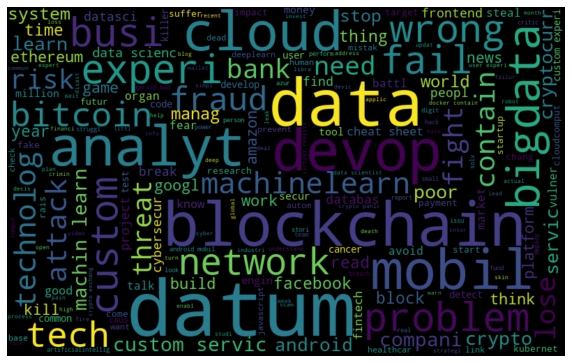

In [24]:
# Common words in the tweets
all_words = ' '.join([text for text in df['clean_text']])
wordcloud = WordCloud(width=800, height=500, random_state=21, max_font_size=110).generate(all_words)

plt.figure(figsize=(10, 7))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.show()

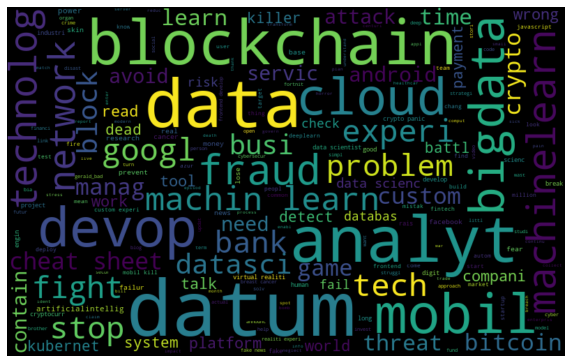

In [25]:
# Positive words
positive_words =' '.join([text for text in df['clean_text'][df['feedback'] == 1]])

wordcloud = WordCloud(width=800, height=500, random_state=21, max_font_size=110).generate(positive_words)
plt.figure(figsize=(10, 7))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.show()

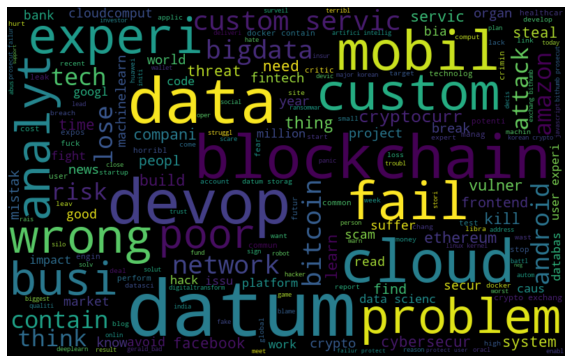

In [26]:
# Negative words
negative_words = ' '.join([text for text in df['clean_text'][df['feedback'] == 0]])
wordcloud = WordCloud(width=800, height=500,
random_state=21, max_font_size=110).generate(negative_words)
plt.figure(figsize=(10, 7))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.show()

In [27]:
# Function to collect hashtag
def hashtag_extract(x):
    hashtags = []
    # Loop over the words in the tweet
    for i in x:
        i = '#'.join([phrase for phrase in [e[1:] for e in i.split("#")]])
        tag = re.findall(r"#(\w+)", i)
        hashtags.append(tag)

    return hashtags

In [28]:
# Extracting hashtags from Positive Response
HT_regular = hashtag_extract(df['clean_text'][df['feedback'] == 0])

# Extracting hashtags from Negative Response
HT_negative = hashtag_extract(df['clean_text'][df['feedback'] == 1])

# Unnesting list
HT_regular = sum(HT_regular,[])
HT_negative = sum(HT_negative,[])

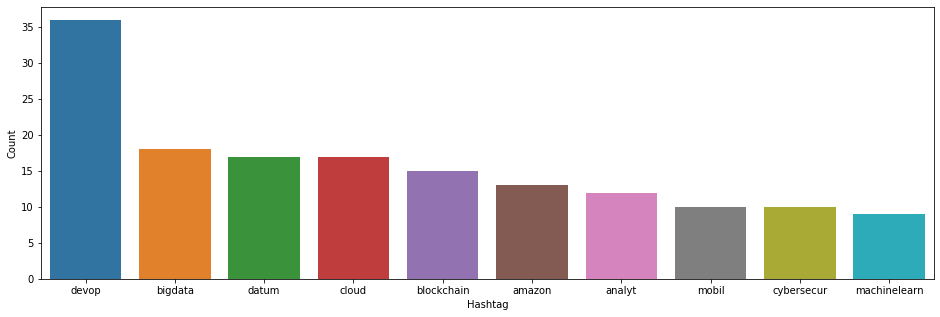

In [29]:
# Positive tweets
a = nltk.FreqDist(HT_regular)
d = pd.DataFrame({'Hashtag': list(a.keys()),
                  'Count': list(a.values())})
# selecting top 10 most frequent hashtags     
d = d.nlargest(columns="Count", n = 10) 
plt.figure(figsize=(16,5))
ax = sns.barplot(data=d, x= "Hashtag", y = "Count")
ax.set(ylabel = 'Count')
plt.show()

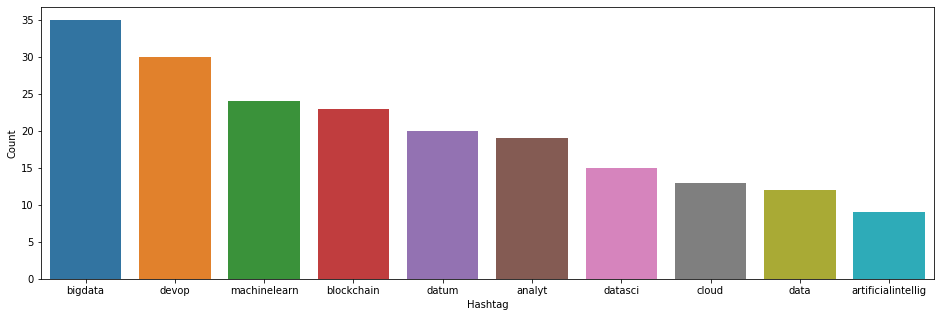

In [30]:
# Negative tweets
a = nltk.FreqDist(HT_negative)
d = pd.DataFrame({'Hashtag': list(a.keys()),
                  'Count': list(a.values())})
# selecting top 10 most frequent hashtags     
d = d.nlargest(columns="Count", n = 10) 
plt.figure(figsize=(16,5))
ax = sns.barplot(data=d, x= "Hashtag", y = "Count")
ax.set(ylabel = 'Count')
plt.show()

In [31]:
from sklearn.feature_extraction.text import CountVectorizer

bow_vectorizer = CountVectorizer(max_df=0.90, min_df=2, max_features=1000, stop_words='english')
# bag-of-words feature matrix
bow = bow_vectorizer.fit_transform(df['clean_text'])

In [32]:
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf_vectorizer = TfidfVectorizer(max_df=0.90, min_df=2, max_features=1000, stop_words='english')
# TF-IDF feature matrix
tfidf = tfidf_vectorizer.fit_transform(df['clean_text'])

In [33]:
bow.shape

(989, 978)

In [34]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score

train_bow = bow[:600,:]
test_bow = bow[600:,:]

# splitting data into training and validation set
xtrain_bow, xvalid_bow, ytrain, yvalid = train_test_split(train_bow, df['feedback'][0:600], random_state=42, test_size=0.3)

lreg = LogisticRegression()

# Training the model
lreg.fit(xtrain_bow, ytrain) 

# Predicting on the validation set
prediction = lreg.predict_proba(xvalid_bow)
# If prediction is greater than or equal to 0.3 than 1 else 0
prediction_int = prediction[:,1] >= 0.3
prediction_int = prediction_int.astype(np.int)

# Calculating f1 score
f1_score(yvalid, prediction_int)

c:\users\admin\appdata\local\programs\python\python36\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


0.6963562753036439

In [35]:
df_test = pd.read_csv("data/flair_labeled_sentiments_long.csv", names=['feedback', 'text'])

df_test = df_test[10000:10389]
print(df_test.shape)

test_pred = lreg.predict_proba(test_bow)
test_pred_int = test_pred[:,1] >= 0.3
test_pred_int = test_pred_int.astype(np.int)
print(len(test_pred_int))
df_test['feedback'] = test_pred_int
submission = df_test[['text', 'feedback']]
submission.to_csv('sub_lreg_bow.csv', index=False) # Writing data to a CSV file

(389, 2)
389


In [36]:
train_tfidf = tfidf[:600,:]
test_tfidf = tfidf[600:,:]

xtrain_tfidf = train_tfidf[ytrain.index]
xvalid_tfidf = train_tfidf[yvalid.index]

lreg.fit(xtrain_tfidf, ytrain)

prediction = lreg.predict_proba(xvalid_tfidf)
prediction_int = prediction[:,1] >= 0.3
prediction_int = prediction_int.astype(np.int)

f1_score(yvalid, prediction_int)

0.6959706959706959